## Compare weighted vote to (naive) majority vote

In [1]:
import os
import sys
curr_dir = os.getcwd()
sys.path.append(os.path.dirname(curr_dir))

import pandas as pd
import numpy as np
import logging
# from sentiment.logger import logger_init

from sentiment.models.sentiment_analysis import Sentiments


2021-12-07 08:28:53,194 loading file /home/fcommo/.flair/models/sentiment-en-mix-distillbert_4.pt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/fcommo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Read file
filepath = os.path.dirname(curr_dir)
filename = "data/sentiment140.csv"
df = pd.read_csv(os.path.join(filepath, filename), error_bad_lines=False, sep=';')

# Get verbatims
verbatims = df.text.to_list()

In [38]:
os.getcwd()

'/mnt/c/Users/fcommo/Documents/Travaux_perso/Python/NLP/Sentiment/notebooks'

In [3]:
# Run predictions
S = Sentiments(verbatims)
sentiments, scores = S.get_predictions()

Some weights of the model checkpoint at VictorSanh/roberta-base-finetuned-yelp-polarity were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/mnt/c/Users/fcommo/Documents/Travaux_perso/Python/NLP/Sentiment/sentiment/models/sentiment_analysis.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [5]:
def accuracy(observed, fitted):
    return np.mean(observed == fitted)

### One-Hot transformation

In [6]:
labels = df['label']
features = sentiments.iloc[:,:-1]

# 1. INSTANTIATE
encoder = preprocessing.OneHotEncoder()

# 2. FIT
encoder.fit(features)

# 3. Transform
onehotlabels = encoder.transform(features).toarray()

### Model training

In [30]:
# Split in train/test sets
X_train, X_test, y_train, y_test = train_test_split(onehotlabels, labels, test_size=0.25, random_state=42)

# Train
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predict
weighted_predictions = clf.predict(X_test)

### Show results

In [34]:
# Show majority vote results

maj_vote = sentiments['majority vote']
acc_maj_vote = accuracy(y_test, maj_vote[y_test.index])
f1_maj_vote = f1_score(y_test, maj_vote[y_test.index], average=None)

for k, v in zip(clf.classes_, f1_maj_vote):
    print("Majority vote F1-score: {}: {:.2f}".format(k, v))

print("Majority vote accuracy: {:.2f}".format(acc_maj_vote))
print()


# Show weighted vote results

acc_weighted_vote = accuracy(y_test, weighted_predictions)
f1_weighted_vote = f1_score(y_test, weighted_predictions, average=None)

for k, v in zip(clf.classes_, f1_weighted_vote):
    print("Weighted vote F1-score: {}: {:.2f}".format(k, v))

print("Weighted vote accuracy: {:.2f}".format(acc_weighted_vote))


Majority vote F1-score: negative: 0.70
Majority vote F1-score: neutral: 0.55
Majority vote F1-score: positive: 0.80
Majority vote accuracy: 0.70

Weighted vote F1-score: negative: 0.81
Weighted vote F1-score: neutral: 0.78
Weighted vote F1-score: positive: 0.81
Weighted vote accuracy: 0.80


In [35]:
def cross_tab(predicted, observed, **kwargs):
    table = pd.crosstab(predicted, observed, **kwargs)
    print(table)
    print()

print("Majority vote:")
cross_tab(maj_vote[y_test.index], y_test, rownames=['Predicted'], colnames=['Truth'])

print("Weighted vote vote:")
cross_tab(weighted_predictions, y_test, rownames=['Predicted'], colnames=['Truth'])

Majority vote:
Truth      negative  neutral  positive
Predicted                             
negative         29       13         3
neutral           3       17         2
positive          6       10        42

Weighted vote vote:
Truth      negative  neutral  positive
Predicted                             
negative         28        2         1
neutral           4       32         6
positive          6        6        40



### Save models

In [36]:
import pickle

In [55]:
path = r"../sentiment/models/weighted_vote"

# Save One-Hot encoder
filename = '/one_hot_encoder.sav'
pickle.dump(encoder, open(path + filename, 'wb'))

# Save LogReg
filename = '/weighted_vote.sav'
pickle.dump(clf, open(path + filename, 'wb'))

In [54]:
path + filename

'../sentiment/models/weighted_vote.sav'

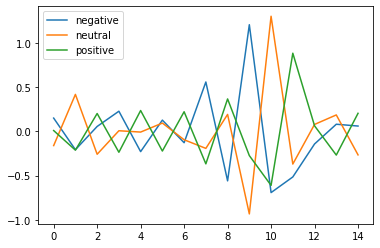

['textblob_label_negative', 'textblob_label_neutral', 'textblob_label_positive']
['flair_label_negative', 'flair_label_positive']
['distilbert_label_negative', 'distilbert_label_positive']
['roberta_label_negative', 'roberta_label_positive']
['twitter_label_negative', 'twitter_label_neutral', 'twitter_label_positive']
['bert_label_negative', 'bert_label_neutral', 'bert_label_positive']


In [9]:
# import matplotlib.pyplot as plt

# # Get model weights
# D = dict(zip(clf.classes_, clf.coef_))

# for k, v in D.items():
#     plt.plot(v)
    
# plt.legend(D.keys())
# plt.show()

# Z = zip(features.columns, encoder.categories_)
# for z in Z:
#     print([f"{z[0]}_{z1}" for z1 in z[1]])